In [1]:
from typing import TypedDict

from browser import ChromeBrowser
from browser.search.web import BraveBrowser
from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task

from dotenv import load_dotenv
load_dotenv()

class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

MAX_STEPS = 5
BRAVE_SEARCH = BraveBrowser(browser=ChromeBrowser(), session_id="deep_web_search")

/Users/maksim.rostov/pdev/freelectron/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
sh: pidof: command not found


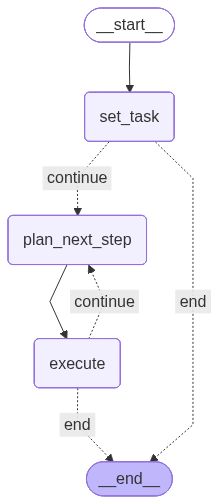

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, \
    AgentCapabilityCodeWriterExecutor, AgentCapabilityAudioProcessor, AgentCapabilityOutput
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[ContentResource] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    state["step"] = 0
    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(
        state["task"].objective,
        state["context"]
    )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] > MAX_STEPS:
        return "end"

    return "continue"

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=state["task"],
        context=state["context"]
    )

    state["capability_plan"] = CapabilityPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    activity, capability = state["capability_plan"].subplan[0]
    output = AgentCapabilityOutput(activity)
    capability_agent = capability(activity)

    if capability is AgentCapabilityDeepWebSearch:
        # Reinitiate the agent since it might need browser
        capability_agent = capability(activity=activity, search_browser=BRAVE_SEARCH)
        output = capability_agent.run()
    elif capability is AgentCapabilityUnstructuredDataProcessor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityCodeWriterExecutor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityAudioProcessor:
        output = capability_agent.run(state["resources"])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    if output.answers:
        state["answers"].extend(output.answers)
    if output.resources:
        state["resources"].extend(output.resources)

    # Update context with step results
    state["context"] += f"\nStep {state['step']}: {state['answers']}"
    state["step"] += 1

    return state


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)

workflow.add_edge(START, "set_task")
workflow.add_conditional_edges(
    "set_task",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)
workflow.add_edge("plan_next_step", "execute")
workflow.add_conditional_edges(
    "execute",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
from generalist.models.core import MLFlowLLMWrapper
from generalist.tools import planning, web_search, text_processing, code

# MONKEY PATCH THE LLM CALLS TO HAVE THE LOGGING IN STDOUT
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

In [4]:
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset

logging.getLogger().setLevel(logging.INFO)
load_dotenv()

gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be"
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632"
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
evaluation_tasks = [
    just_running_python_task_id,
    calc_sales_xlsx_task_id,
    sosa_many_studio_albums_task_id,
    running_to_the_moon_task_id,
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys]

    mlflow.langchain.autolog()                                                 # this is needed to register traces within the experiment
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    # mlflow.set_tracking_uri('http://localhost:5000')

    question = sample["Question"]
    resources = []
    if sample["file_path"]:
        resource = ContentResource(
            provided_by="user",
            content="file provided with the main task",
            link=os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"]),
            metadata={"note":"the file is already in the list of available resources"}
        )
        print(resource.link)
        resources.append(resource)
    initial_state = init_state(question, resources=resources)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).
2026/01/16 12:58:52 INFO mlflow.tracking.fluent: Experiment with name 'gaia_f918266a_b3e0_4914_865d_4faa564f1aef' does not exist. Creating a new experiment.


task_id = f918266a-b3e0-4914-865d-4faa564f1aef
Question = What is the final numeric output from the attached Python code?
Level = 1
Final answer = 0
file_name = f918266a-b3e0-4914-865d-4faa564f1aef.py
file_path = 2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py
Annotator Metadata = {'Steps': '1. Run the attached Python code', 'Number of steps': '1', 'How long did this take?': '30 seconds', 'Tools': '1. Python', 'Number of tools': '1'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py


2026-01-16 12:59:23,565 - generalist.tools.summarisers - INFO - - construct_short_answer -- Short answer:
{
    "answered": "false",
    "answer": "not found",
    "clarification": "There are no Python code or numerical output details provided in the resources, hence the task cannot be completed based on the given information."
}.
2026-01-16 12:59:37,164 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Execute the provided Python script to generate the final numeric output",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-16 13:00:18,918 - generalist.agents.core - INFO - - code_writing_execution -- EDA code to be executed:
```python
import os

# Define the file paths provided in the resources
file_paths = [
    '/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py',
    '/Users/maksim.rostov/pdev/freelectron/free-generalist/eval

task_id = 7bd855d8-463d-4ed5-93ca-5fe35145f733
Question = The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
Level = 1
Final answer = 89706.00
file_name = 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
file_path = 2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
Annotator Metadata = {'Steps': '1. Open the attached file.\n2. Read the columns representing different menu items. Note that they all appear to be food except for the “soda” column.\n3. Write a function to sum the relevant columns.\n4. Ensure the answer follows the specified formatting.', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. Excel\n2. Calculator', 'Number of tools': '2'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


2026-01-16 13:03:47,189 - generalist.tools.summarisers - INFO - - construct_short_answer -- Short answer:
{
    "answered": "false",
    "answer": "not found",
    "clarification": "The resources do not provide any information about sales data for a local fast-food chain, let alone specifying total sales from food items excluding drinks. Therefore, the task cannot be answered based on the given resources."
}.
2026-01-16 13:04:06,076 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Open the provided Excel file and identify columns representing food sales excluding drinks",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-16 13:04:40,482 - generalist.agents.core - INFO - - code_writing_execution -- EDA code to be executed:
```python
import pandas as pd

# Load the Excel file containing sales data of menu items
file_path = '/Users/maksim.rostov/pdev/freeelectron/free-generalist/evaluation/gaia/2023/valid

task_id = 8e867cd7-cff9-4e6c-867a-ff5ddc2550be
Question = How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Level = 1
Final answer = 3
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. I did a search for Mercedes Sosa\n2. I went to the Wikipedia page for her\n3. I scrolled down to "Studio albums"\n4. I counted the ones between 2000 and 2009', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. web browser\n2. google search', 'Number of tools': '2'}


2026-01-16 13:06:34,703 - generalist.tools.summarisers - INFO - - construct_short_answer -- Short answer:
{
    "answered": "false",
    "answer": "not found",
    "clarification": "There are no resources provided that contain information about Mercedes Sosa's studio albums published between 2000 and 2009 according to the latest 2022 version of English Wikipedia."
}.
2026-01-16 13:06:56,554 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Search for the Mercedes Sosa's Wikipedia page and locate the section detailing her discography.",
      "capability": "deep_web_search"
    }
  ]
}
2026-01-16 13:06:59,691 - generalist.tools.web_search - INFO - - web_search -- Generated queries: ['Mercedes Sosa discography Wikipedia']
2026-01-16 13:07:03,480 - generalist.tools.web_search - INFO - Found 1 unique sources.
[WebSearchResult(link='https://en.wikipedia.org/wiki/Mercedes_Sosa', metadata={'search_order': 0, 'web_page_title'

task_id = e1fc63a2-da7a-432f-be78-7c4a95598703
Question = If Eliud Kipchoge could maintain his record-making marathon pace indefinitely, how many thousand hours would it take him to run the distance between the Earth and the Moon its closest approach? Please use the minimum perigee value on the Wikipedia page for the Moon when carrying out your calculation. Round your result to the nearest 1000 hours and do not use any comma separators if necessary.
Level = 1
Final answer = 17
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. Googled Eliud Kipchoge marathon pace to find 4min 37sec/mile\n2. Converted into fractions of hours.\n3. Found moon periapsis in miles (225,623 miles).\n4. Multiplied the two to find the number of hours and rounded to the nearest 100 hours.', 'Number of steps': '4', 'How long did this take?': '20 Minutes', 'Tools': '1. A web browser.\n2. A search engine.\n3. A calculator.', 'Number of tools': '3'}


2026-01-16 13:12:37,961 - generalist.tools.summarisers - INFO - - construct_short_answer -- Short answer:
{
    "answered": "false",
    "answer": "not found",
    "clarification": "There are no resources provided that contain information about Eliud Kipchoge's marathon record pace, the distance from Earth to the Moon at its minimum perigee value, or any relevant calculations needed to answer the task."
}.
2026-01-16 13:13:03,335 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Search for the minimum perigee distance of the Moon from Earth and Eliud Kipchoge's world record marathon time to calculate his pace in kilometers per hour",
      "capability": "deep_web_search"
    }
  ]
}
2026-01-16 13:13:07,260 - generalist.tools.web_search - INFO - - web_search -- Generated queries: ['Minimum perigee distance Moon Earth km']
2026-01-16 13:13:11,542 - generalist.tools.web_search - INFO - Found 1 unique sources.
[WebSearchR

ReadTimeout: timed out